In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [20]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [24]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./model/lenet_mnist_model.pth"
use_cuda=True

In [25]:
import torch.nn as nn
import torch.nn.functional as F

# LeNet Model definition
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [26]:
# MNIST Train dataset and dataloader declaration
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./train_data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [27]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = LeNet5().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


LeNet5(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [28]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [29]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [30]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4300 / 10000 = 0.43
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 868 / 10000 = 0.0868


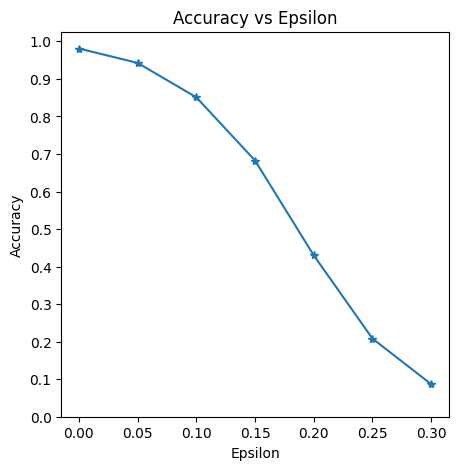

In [31]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

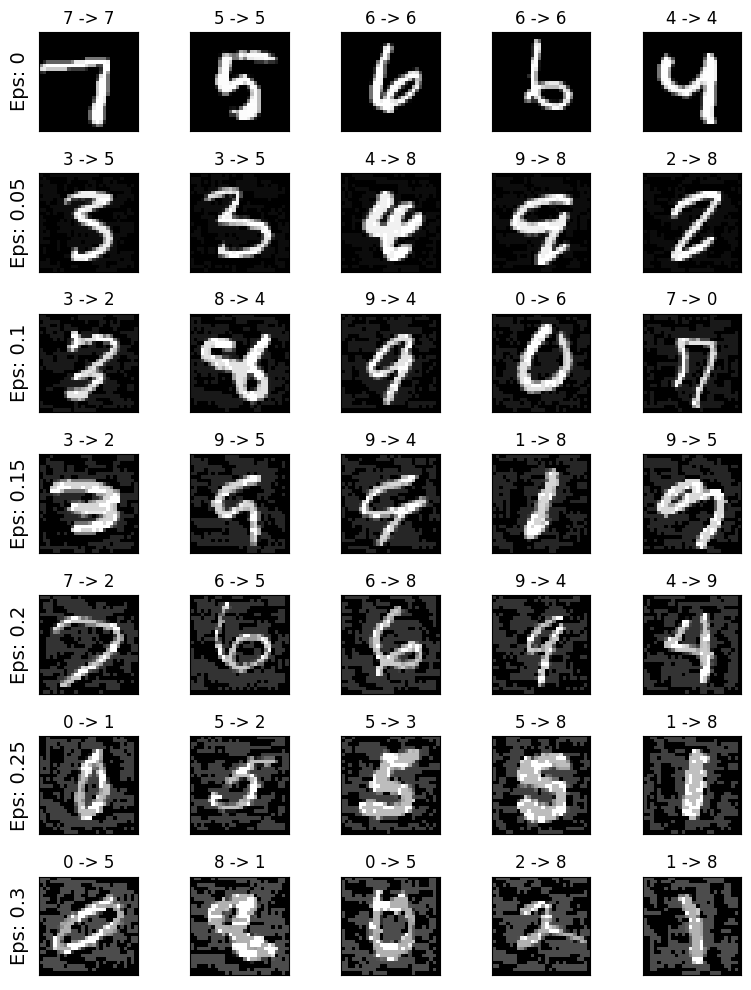

In [32]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [36]:
!pip install git+https://github.com/CNOCycle/cleverhans.git@feature/tf2.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/CNOCycle/cleverhans.git (to revision feature/tf2.x) to /tmp/pip-req-build-4ivia3ps
  Running command git clone --filter=blob:none --quiet https://github.com/CNOCycle/cleverhans.git /tmp/pip-req-build-4ivia3ps
  Running command git checkout -b feature/tf2.x --track origin/feature/tf2.x
  Switched to a new branch 'feature/tf2.x'
  Branch 'feature/tf2.x' set up to track remote branch 'feature/tf2.x' from 'origin'.
  Resolved https://github.com/CNOCycle/cleverhans.git to commit b103b0caf983331ec9c5f7c3e08e417a85bf25e2
  Preparing metadata (setup.py) ... done


In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import warnings
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms

from cleverhans.compat import flags
from cleverhans.dataset import MNIST
from cleverhans.utils import AccuracyReport

In [35]:
from cleverhans.future.torch.attacks.fast_gradient_method import fast_gradient_method

In [36]:
FLAGS = flags.FLAGS
NB_EPOCHS = 2
BATCH_SIZE = 128
LEARNING_RATE = .001

def trainTorch(torch_model, train_loader, test_loader,
        nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE, train_end=-1, test_end=-1, learning_rate=LEARNING_RATE, optimizer=None):

    train_loss = []
    total = 0
    correct = 0
    step = 0
    for _epoch in range(nb_epochs):
      for xs, ys in train_loader:
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
          xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients

        preds_np = preds.cpu().detach().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        total += train_loader.batch_size
        step += 1
        if total % 1000 == 0:
          acc = float(correct) / total
          print('[%s] Training accuracy: %.2f%%' % (step, acc * 100))
          total = 0
          correct = 0

In [37]:
#Evaluate results on clean data
def evalClean(model1=None, test_loader=None):
    print("Evaluating single model results on clean data")
    total = 0
    correct = 0
    with torch.no_grad():
      model1.eval()
      for xs, ys in test_loader:
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
          xs, ys = xs.cuda(), ys.cuda()
        preds1 = model1(xs)
        preds_np1 = preds1.cpu().detach().numpy()
        finalPred = np.argmax(preds_np1, axis=1)
        correct += (finalPred == ys.cpu().detach().numpy()).sum()
        total += len(xs)
    acc = float(correct) / total
    print('Clean accuracy: %.2f%%' % (acc * 100))

#Evaluate results on adversarially perturbed 
def evalAdvAttack(fgsm_model=None, test_loader=None):
    print("Evaluating single model results on adv data")
    total = 0
    correct = 0
    fgsm_model.eval()
    for xs, ys in test_loader:
      if torch.cuda.is_available():
        xs, ys = xs.cuda(), ys.cuda()
      #pytorch fast gradient method
      xs = fast_gradient_method(fgsm_model, xs, eps=0.3, norm=np.inf, clip_min=0., clip_max=1.)
      # xs = fast_gradient_method(fgsm_model, xs, eps=0.1, norm=np.inf)
      xs, ys = Variable(xs), Variable(ys)
      preds1 = fgsm_model(xs)
      preds_np1 = preds1.cpu().detach().numpy()
      finalPred = np.argmax(preds_np1, axis=1)
      correct += (finalPred == ys.cpu().detach().numpy()).sum()
      total += test_loader.batch_size
    acc = float(correct) / total
    print('Adv accuracy: {:.3f}％'.format(acc * 100))

In [38]:
#Adversarial Training
def advTrain(torch_model, train_loader, test_loader,
        nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE, train_end=-1, test_end=-1, learning_rate=LEARNING_RATE):
    optimizer = optim.Adam(torch_model.parameters(), lr=learning_rate)
    train_loss = []
    total = 0
    correct = 0
    totalAdv = 0
    correctAdv = 0
    step = 0
    # breakstep = 0
    for _epoch in range(nb_epochs):
      for xs, ys in train_loader:
        #Normal Training
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
          xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correct += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        total += train_loader.batch_size

        #Adversarial Training
        xs = fast_gradient_method(torch_model, xs, eps=0.3, norm=np.inf, clip_min=0., clip_max=1.)
        xs, ys = Variable(xs), Variable(ys)
        if torch.cuda.is_available():
            xs, ys = xs.cuda(), ys.cuda()
        optimizer.zero_grad()
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        loss.backward()  # calc gradients
        train_loss.append(loss.data.item())
        optimizer.step()  # update gradients
        preds_np = preds.cpu().detach().numpy()
        correctAdv += (np.argmax(preds_np, axis=1) == ys.cpu().detach().numpy()).sum()
        totalAdv += train_loader.batch_size
        
        step += 1
        if total % 1000 == 0:
          acc = float(correct) / total
          print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
          total = 0
          correct = 0
          accAdv = float(correctAdv) / totalAdv
          print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))
          totalAdv = 0
          correctAdv = 0

In [39]:
#Initialize model
model1 = LeNet5()
if torch.cuda.is_available():
  model1 = model1.cuda()
nb_epochs = 4
batch_size = 128
learning_rate = 0.001
train_end = -1
test_end = -1
report = AccuracyReport()

In [40]:
#Training the model
print("Training Model")
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
trainTorch(model1, train_loader, test_loader, nb_epochs, batch_size, train_end, test_end, learning_rate, optimizer = optimizer)

Training Model
[1000] Training accuracy: 36.80%
[2000] Training accuracy: 67.40%
[3000] Training accuracy: 74.60%
[4000] Training accuracy: 77.90%
[5000] Training accuracy: 83.30%
[6000] Training accuracy: 81.90%
[7000] Training accuracy: 85.00%
[8000] Training accuracy: 86.80%
[9000] Training accuracy: 86.10%
[10000] Training accuracy: 87.20%
[11000] Training accuracy: 90.20%
[12000] Training accuracy: 88.80%
[13000] Training accuracy: 87.70%
[14000] Training accuracy: 88.70%
[15000] Training accuracy: 88.50%
[16000] Training accuracy: 88.60%
[17000] Training accuracy: 89.10%
[18000] Training accuracy: 88.50%
[19000] Training accuracy: 89.60%
[20000] Training accuracy: 88.60%
[21000] Training accuracy: 89.80%
[22000] Training accuracy: 88.40%
[23000] Training accuracy: 90.80%
[24000] Training accuracy: 87.50%
[25000] Training accuracy: 90.90%
[26000] Training accuracy: 91.10%
[27000] Training accuracy: 90.60%
[28000] Training accuracy: 89.90%
[29000] Training accuracy: 91.90%
[30000] 

In [41]:
#Evaluation
evalClean(model1, test_loader)
evalAdvAttack(model1, test_loader)

Evaluating single model results on clean data
Clean accuracy: 97.59%
Evaluating single model results on adv data
Adv accuracy: 14.980％


In [42]:
print("Training on Adversarial Samples")
advTrain(model1, train_loader, test_loader, nb_epochs, batch_size, train_end, test_end, learning_rate)

Training on Adversarial Samples
[1000] Clean Training accuracy: 96.80%
[1000] Adv Training accuracy: 33.20%
[2000] Clean Training accuracy: 96.00%
[2000] Adv Training accuracy: 53.20%
[3000] Clean Training accuracy: 95.40%
[3000] Adv Training accuracy: 57.10%
[4000] Clean Training accuracy: 95.30%
[4000] Adv Training accuracy: 59.40%
[5000] Clean Training accuracy: 94.70%
[5000] Adv Training accuracy: 61.90%
[6000] Clean Training accuracy: 94.10%
[6000] Adv Training accuracy: 61.30%
[7000] Clean Training accuracy: 94.30%
[7000] Adv Training accuracy: 61.50%
[8000] Clean Training accuracy: 94.30%
[8000] Adv Training accuracy: 67.00%
[9000] Clean Training accuracy: 95.70%
[9000] Adv Training accuracy: 66.60%
[10000] Clean Training accuracy: 95.40%
[10000] Adv Training accuracy: 67.70%
[11000] Clean Training accuracy: 95.10%
[11000] Adv Training accuracy: 72.40%
[12000] Clean Training accuracy: 95.70%
[12000] Adv Training accuracy: 71.10%
[13000] Clean Training accuracy: 95.90%
[13000] Ad

In [43]:
#Evaluating Again
evalClean(model1, test_loader)
evalAdvAttack(model1, test_loader)

Evaluating single model results on clean data
Clean accuracy: 96.87%
Evaluating single model results on adv data
Adv accuracy: 91.620％
